In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
az.rcParams["plot.density_kind"] = "hist"
rng = np.random.default_rng(seed=42)


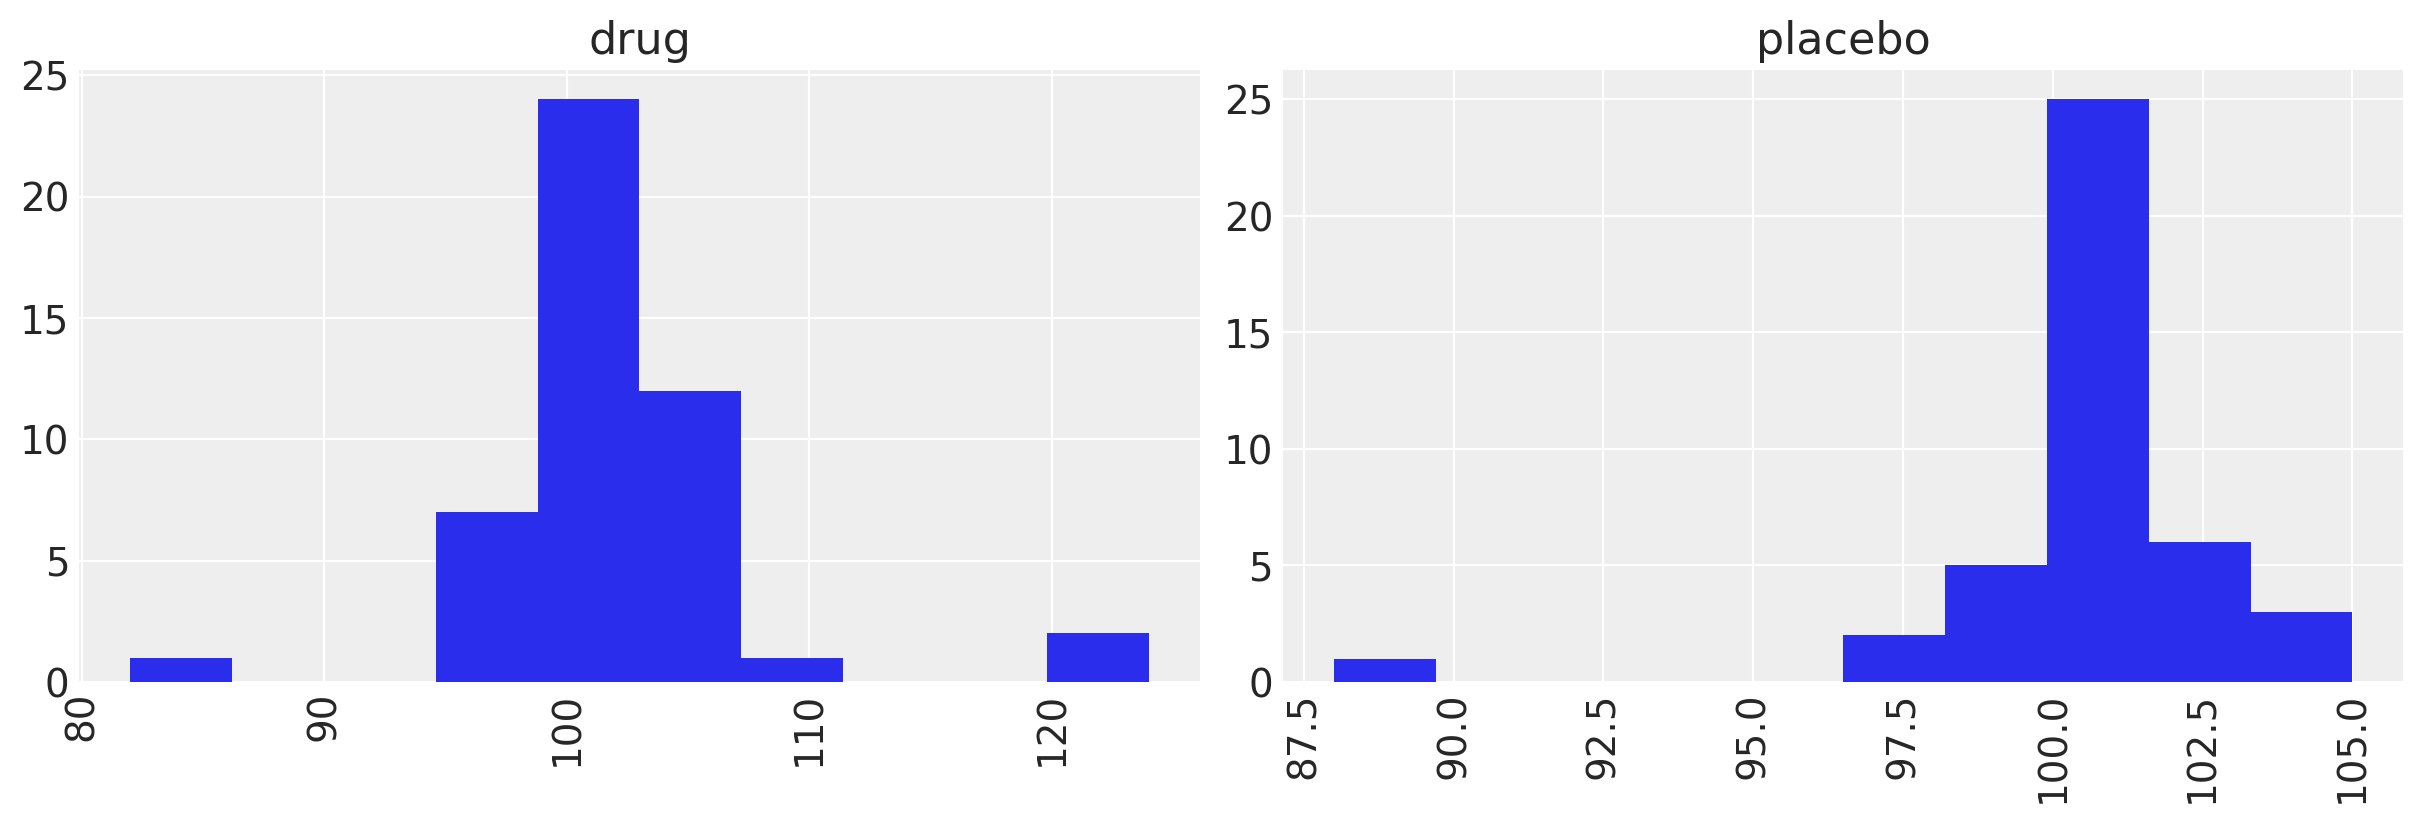

In [3]:
# Using data from pymc3 port of Kruschke's BEST model (see: 
# https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html)
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(
    dict(value=np.r_[y1, y2], group=np.r_[["drug"] * len(drug), ["placebo"] * len(placebo)])
)

y.hist("value", by="group", figsize=(12, 4));

In [4]:
# Call your Bayesian function from the toolbox
# model, idata = bst.BEST(y["value"], y["group"], 2000)
model, idata = bst.BEST_copy(y["value"], y["group"], 2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [17]:
dummy = y.group.astype("category")
dummy_vals = dummy.cat.codes.values
d_level = dummy.cat.categories
type(dummy_vals)

numpy.ndarray

In [5]:
# Print out a summary of results
az.summary(idata)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_mean[0],101.555,0.380,100.797,102.283,0.005,0.003,6329.0,4844.0,1.0
group_mean[1],100.527,0.216,100.116,100.950,0.003,0.002,7135.0,5407.0,1.0
group_std[0],2.060,0.435,1.257,2.902,0.006,0.004,6027.0,5296.0,1.0
group_std[1],1.054,0.208,0.674,1.456,0.003,0.002,6119.0,4867.0,1.0
nu_minus_one,0.842,0.479,0.060,1.771,0.006,0.004,5483.0,4524.0,1.0
nu,1.842,0.479,1.060,2.771,0.006,0.004,5483.0,4524.0,1.0
nu_log10,0.252,0.107,0.050,0.463,0.001,0.001,5483.0,4524.0,1.0
difference of means,1.029,0.440,0.206,1.922,0.005,0.004,6500.0,5294.0,1.0
difference of stds,1.005,0.437,0.236,1.906,0.005,0.004,7067.0,5914.0,1.0
effect size,0.646,0.296,0.063,1.204,0.004,0.003,6703.0,4987.0,1.0


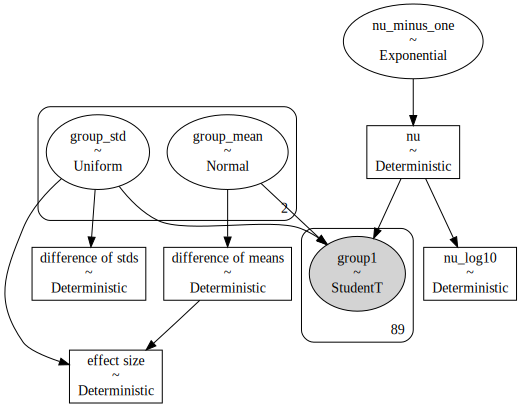

In [6]:
pm.model_to_graphviz(model)

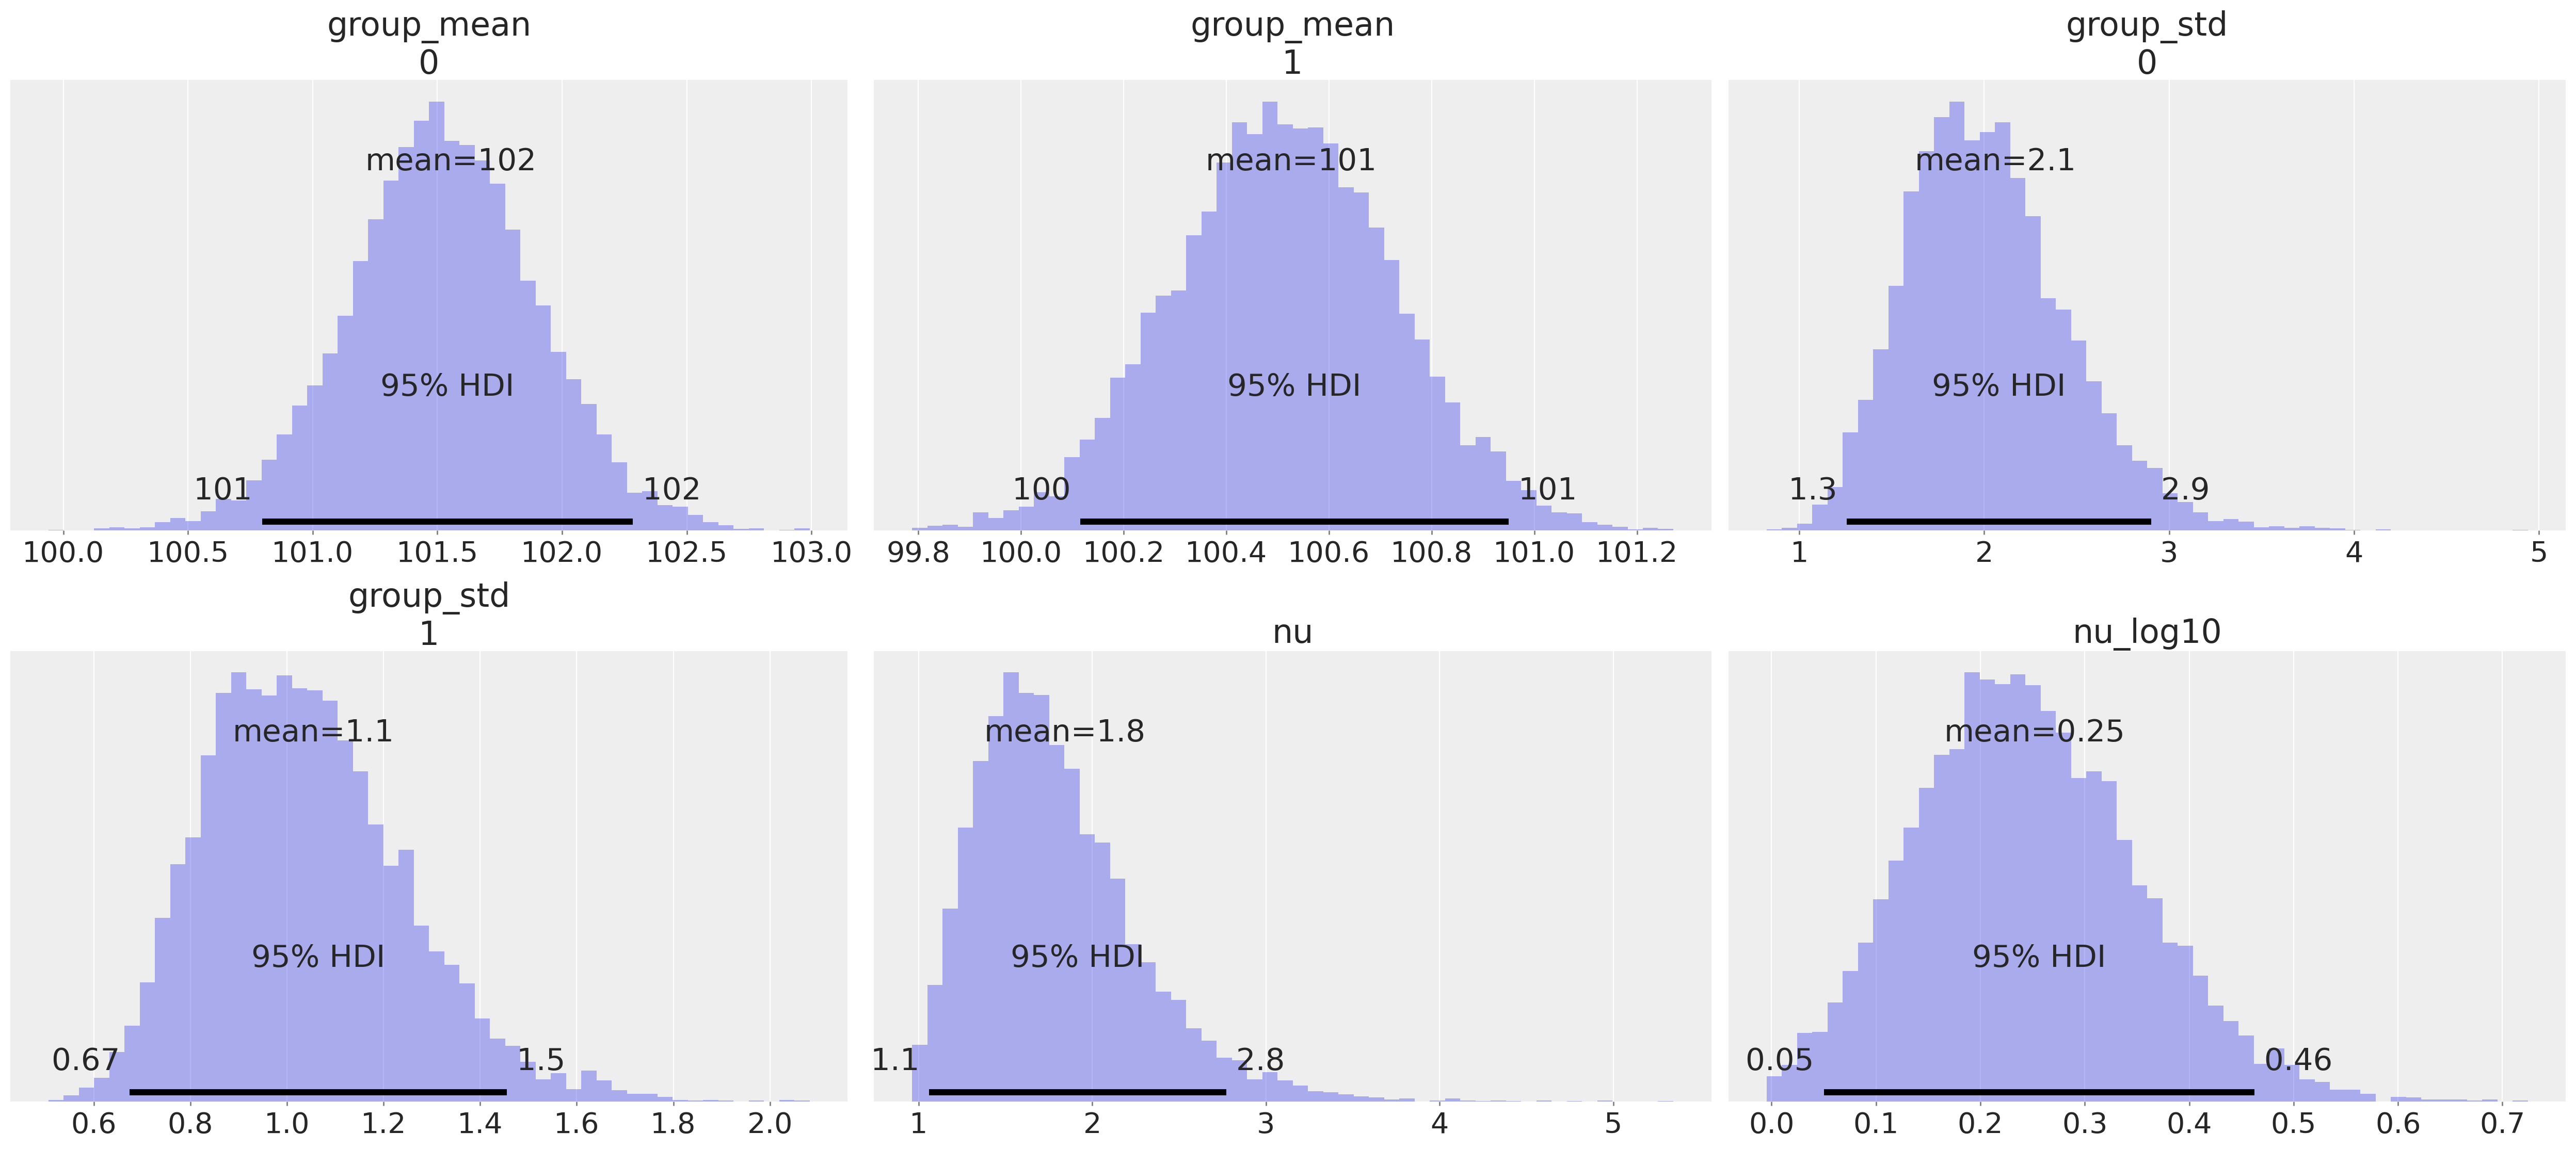

In [9]:
# Plot posterior
# az.plot_posterior(
#     idata,
#     var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "nu", "nu_log10"],
#     bins=50,
#     textsize=20
# );
az.plot_posterior(
    idata,
    var_names=["group_mean", "group_std",  "nu", "nu_log10"],
    bins=50,
    textsize=20
);

In [ ]:
# idata_posterior = idata.posterior


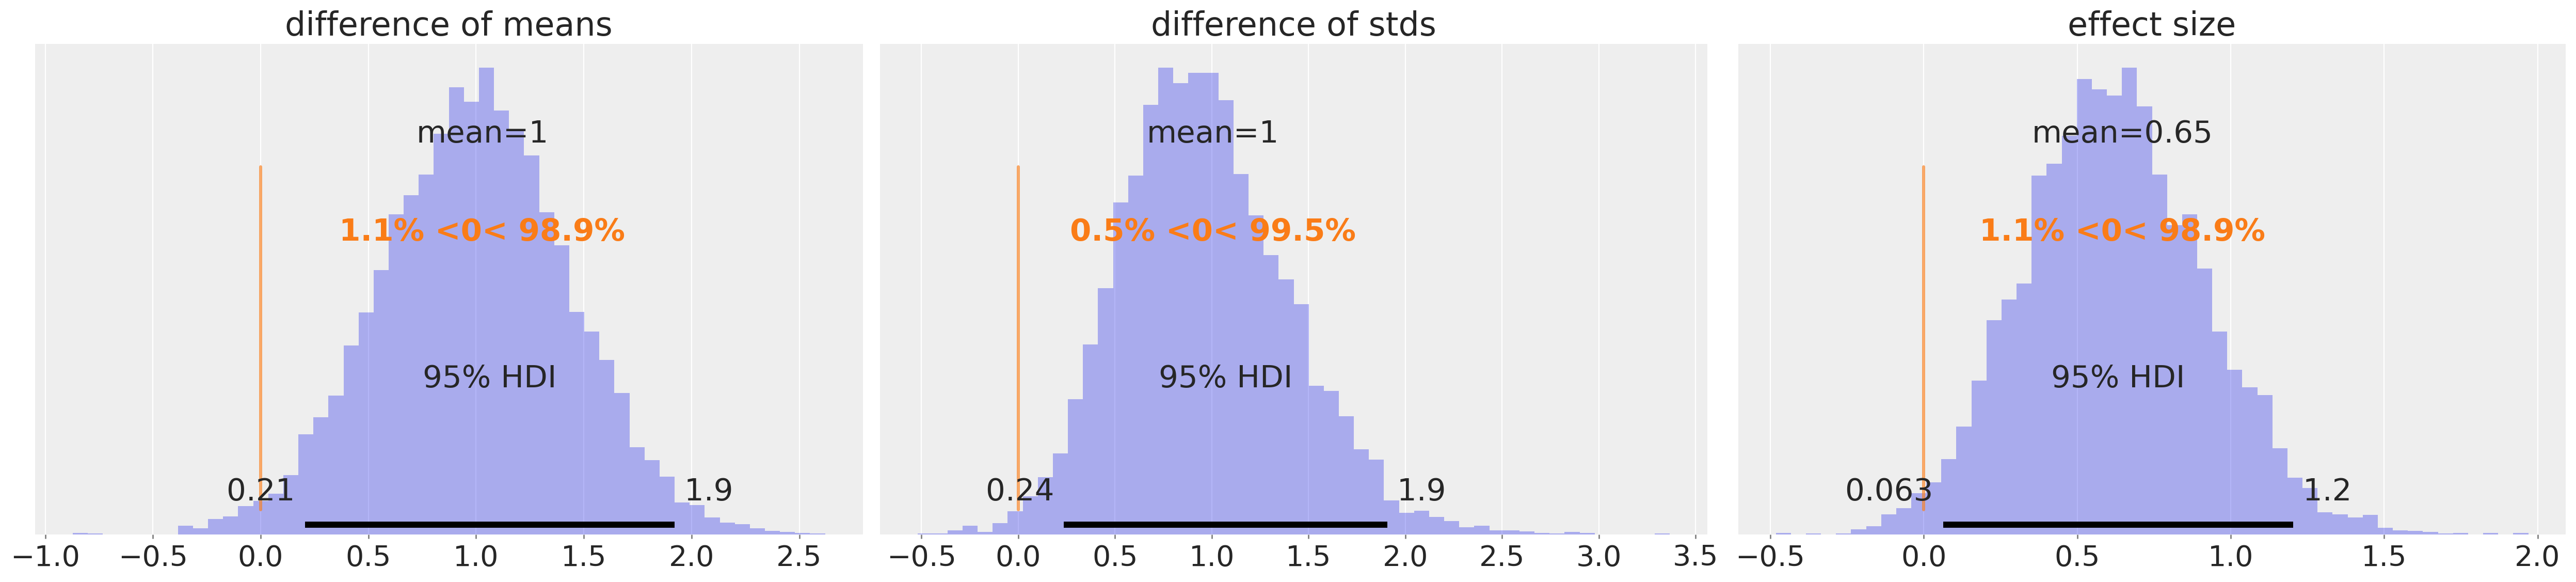

In [7]:
# Plot posterior
az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    bins=50,
    textsize=20
);

In [ ]:
# Plot parameter estimates
az.plot_forest(idata, var_names=["group1_mean", "group2_mean"], combined=True);

In [ ]:
# Plot parameter estimates
az.plot_forest(idata, var_names=["group1_std", "group2_std", "nu"]);

In [ ]:
# If you want to print the model so that you edit, simply add two question marks after the function name.
bst.BEST??

In [ ]:
# Assess your MCMC chains.
az.plot_trace(idata);

In [ ]:
# Posterior predictive check
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
az.plot_ppc(idata, var_names=["group1", "group2"], num_pp_samples=50);

In [ ]:
az.rcParams.keys()

In [ ]:
plt.rcParams